<a href="https://colab.research.google.com/github/MultimodalUniverse/MultimodalUniverse/blob/main/notebooks/getting_started.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright 2024 Multimodal Universe Collaboration

Licensed under MIT License (the "License")

**Authors**:
- [@EiffL](https://github.com/EiffL) (Francois Lanusse)

# Getting Started with the Multimodal Universe Dataset!

<p align="center">
<img src="https://raw.githubusercontent.com/MultimodalUniverse/MultimodalUniverse/main/assets/mmu.png" alt="drawing" width="400"/>
<p>

### Overview

In this notebook we demonstrate how to access the data from the Multimodal Universe dataset, provide explanations about how to understand and work with each modality, and provide examples of multimodal cross-matching.

### Learning Objectives

In this notebook, we will learn how to:
 - Access datasets of different modalities
 - Cross-match different datasets


### Installs and Imports

To get started with the dataset, we only need to install Hugging Face Datasets:

In [ ]:
# Installing Hugging Face datasets
!pip install datasets --quiet

And that's it, we are set 😀 Let's just import a few things and then we can get started:

In [2]:
%pylab inline
from datasets import load_dataset

Populating the interactive namespace from numpy and matplotlib


## Image Samples


In [3]:
dset_ls = load_dataset("MultimodalUniverse/legacysurvey",
                       streaming=True,
                       split='train')
dset_ls = dset_ls.with_format("numpy")
dset_iterator = iter(dset_ls)

In [4]:
example = next(dset_iterator)

In [5]:
# Let's inspect what is contained in an example
example.keys()

dict_keys(['image', 'model_image', 'object_mask', 'catalog', 'EBV', 'FLUX_G', 'FLUX_R', 'FLUX_I', 'FLUX_Z', 'FLUX_W1', 'FLUX_W2', 'FLUX_W3', 'FLUX_W4', 'object_id'])

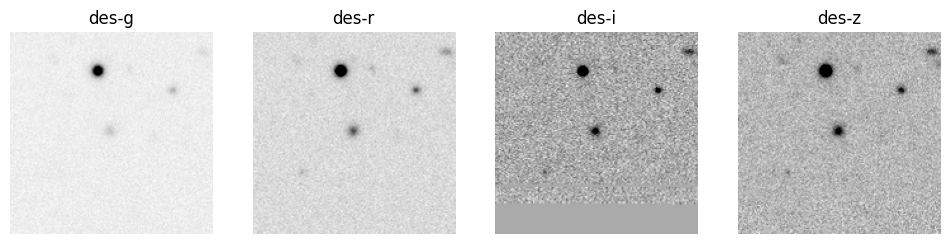

In [6]:
figure(figsize=(12,4))
for i,b in enumerate(example['image']['band']):
  subplot(1,4,i+1)
  title(f'{b}')
  imshow(example['image']['array'][i],vmax=0.1, cmap='gray_r')
  axis('off')

## Spectra Samples

In [7]:
dset_sdss = load_dataset("MultimodalUniverse/sdss",
                       streaming=True,
                       split='train')
dset_sdss = dset_sdss.with_format("numpy")
dset_iterator = iter(dset_sdss)

In [8]:
example = next(dset_iterator)

In [9]:
# Let's inspect what is contained in an example
example.keys()

dict_keys(['spectrum', 'VDISP', 'VDISP_ERR', 'Z', 'Z_ERR', 'ZWARNING', 'SPECTROFLUX_U', 'SPECTROFLUX_G', 'SPECTROFLUX_R', 'SPECTROFLUX_I', 'SPECTROFLUX_Z', 'SPECTROFLUX_IVAR_U', 'SPECTROFLUX_IVAR_G', 'SPECTROFLUX_IVAR_R', 'SPECTROFLUX_IVAR_I', 'SPECTROFLUX_IVAR_Z', 'SPECTROSYNFLUX_U', 'SPECTROSYNFLUX_G', 'SPECTROSYNFLUX_R', 'SPECTROSYNFLUX_I', 'SPECTROSYNFLUX_Z', 'SPECTROSYNFLUX_IVAR_U', 'SPECTROSYNFLUX_IVAR_G', 'SPECTROSYNFLUX_IVAR_R', 'SPECTROSYNFLUX_IVAR_I', 'SPECTROSYNFLUX_IVAR_Z', 'object_id'])

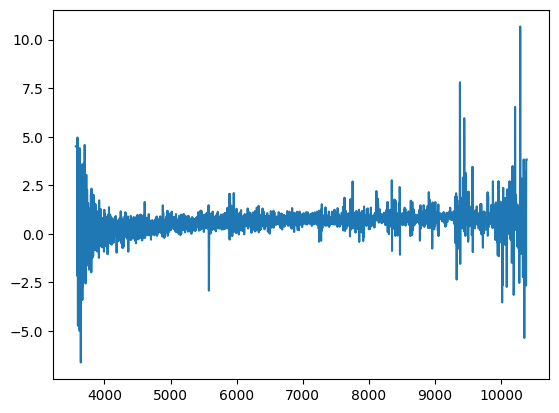

In [10]:
# For plotting, we remove the padding values that are recognizable by the -1
m = example['spectrum']['lambda'] > 0

plot(example['spectrum']['lambda'][m],
     example['spectrum']['flux'][m])

## Time-Series sample

In [11]:
dset_plasticc = load_dataset("MultimodalUniverse/plasticc",
                       streaming=True,
                       split='train')
dset_plasticc = dset_plasticc.with_format("numpy")
dset_iterator = iter(dset_plasticc)

In [12]:
example = next(dset_iterator)

In [13]:
example.keys()

dict_keys(['lightcurve', 'hostgal_photoz', 'hostgal_specz', 'redshift', 'obj_type', 'object_id'])

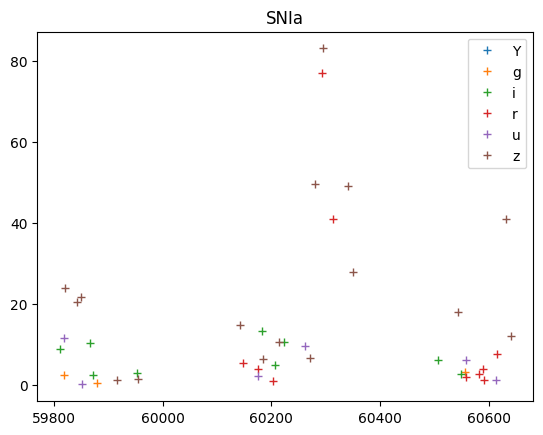

In [14]:
for b in unique(example['lightcurve']['band']):
  m = (example['lightcurve']['flux'] > 0) & (example['lightcurve']['band'] == b)
  plot(example['lightcurve']['time'][m],
      example['lightcurve']['flux'][m],'+', label=b)
  title(example['obj_type'])
legend();

## Cross-Matching Across Modalities

While each parent sample is based on a single modality, users can easily create datasets across modalities by using the provided utilities.

This requires downloading the datasets to cross-match locally on local storage, and installing our utility library.


In the example below, we download a small fraction of 2 parent samples for demonstration purposes. For real applications, please see the project README to see how to download entire datasets.


#### - Installing the utility library

In [ ]:
!pip install git+https://github.com/MultimodalUniverse/MultimodalUniverse.git --quiet

#### - Downloading a small fraction of the data

The lines below download specifically a matching small healpix region of both the HSC imaging sample, and the SDSS spectroscospic dataset.

In [24]:
# Downloading a small fraction of the data for demonstration purposes
!wget -r -np -nH --cut-dirs=1 -R "index.html*" -q https://users.flatironinstitute.org/~flanusse/MultimodalUniverse/hsc/pdr3_dud_22.5/healpix=1175/
!wget -r -np -nH --cut-dirs=1 -R "index.html*" -q https://users.flatironinstitute.org/~flanusse/MultimodalUniverse/hsc/hsc.py
!wget -r -np -nH --cut-dirs=1 -R "index.html*" -q https://users.flatironinstitute.org/~flanusse/MultimodalUniverse/sdss/sdss/healpix=1175/
!wget -r -np -nH --cut-dirs=1 -R "index.html*" -q https://users.flatironinstitute.org/~flanusse/MultimodalUniverse/sdss/sdss.py

#### - Building cross-matched dataset

In [27]:
from datasets import load_dataset_builder
from astropile.utils import cross_match_datasets

In [33]:
# Load the dataset descriptions from local copy of the data
sdss = load_dataset_builder("MultimodalUniverse/sdss", trust_remote_code=True)
hsc = load_dataset_builder("MultimodalUniverse/hsc", trust_remote_code=True)

In [35]:
# Use the cross matching utility to return a new HF dataset, the intersection
# of the parent samples.
dset = cross_match_datasets(sdss, # Left dataset
                            hsc,  # Right dataset
                            matching_radius=1.0, # Distance in arcsec
                            )

Initial number of matches:  25
Number of matches lost at healpix region borders:  0
Final size of cross-matched catalog:  25


In [36]:
# The resulting dataset contains columns from both parent samples
dset

Dataset({
    features: ['spectrum', 'VDISP', 'VDISP_ERR', 'Z', 'Z_ERR', 'ZWARNING', 'SPECTROFLUX_U', 'SPECTROFLUX_G', 'SPECTROFLUX_R', 'SPECTROFLUX_I', 'SPECTROFLUX_Z', 'SPECTROFLUX_IVAR_U', 'SPECTROFLUX_IVAR_G', 'SPECTROFLUX_IVAR_R', 'SPECTROFLUX_IVAR_I', 'SPECTROFLUX_IVAR_Z', 'SPECTROSYNFLUX_U', 'SPECTROSYNFLUX_G', 'SPECTROSYNFLUX_R', 'SPECTROSYNFLUX_I', 'SPECTROSYNFLUX_Z', 'SPECTROSYNFLUX_IVAR_U', 'SPECTROSYNFLUX_IVAR_G', 'SPECTROSYNFLUX_IVAR_R', 'SPECTROSYNFLUX_IVAR_I', 'SPECTROSYNFLUX_IVAR_Z', 'object_id', 'image', 'a_g', 'a_r', 'a_i', 'a_z', 'a_y', 'g_extendedness_value', 'r_extendedness_value', 'i_extendedness_value', 'z_extendedness_value', 'y_extendedness_value', 'g_cmodel_mag', 'g_cmodel_magerr', 'r_cmodel_mag', 'r_cmodel_magerr', 'i_cmodel_mag', 'i_cmodel_magerr', 'z_cmodel_mag', 'z_cmodel_magerr', 'y_cmodel_mag', 'y_cmodel_magerr', 'g_sdssshape_psf_shape11', 'g_sdssshape_psf_shape22', 'g_sdssshape_psf_shape12', 'r_sdssshape_psf_shape11', 'r_sdssshape_psf_shape22', 'r_sdsss

In [ ]:
# Formating HF Dataset to JAX
dset = dset.with_format('jax')

We now have a dataset that contains both images and spectra of the same object.

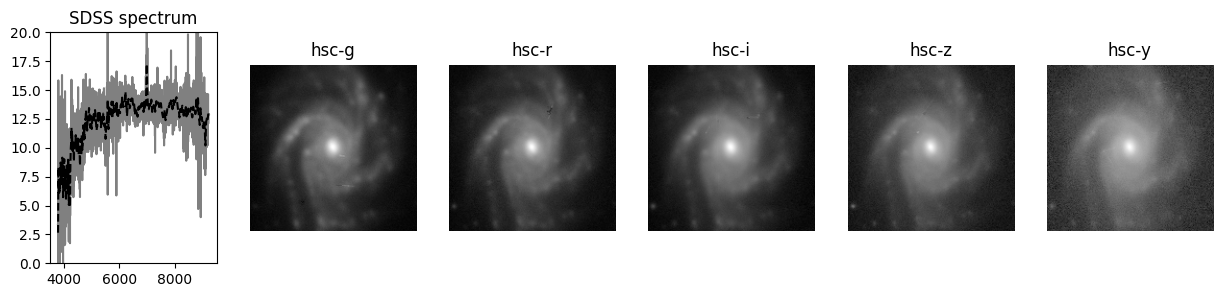

In [56]:
example = dset[3]

from scipy.ndimage import gaussian_filter1d
figure(figsize=[15,3])
subplot(1,6,1)
ylim(0,20)
m = example['spectrum']['lambda'] > 0
plot(example['spectrum']['lambda'][m], example['spectrum']['flux'][m], color='gray')
plot(example['spectrum']['lambda'][m], gaussian_filter1d(example['spectrum']['flux'], sigma=5)[m], color='k')

title('SDSS spectrum')
for i in range (5):
    subplot(1,6,i+2)
    imshow(log10(example['image']['array'][i] + 2.), cmap='gray')
    title(example['image']['band'][i])
    axis('off')